In [1]:
import random
import sys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scripts.data_generator as data_generator
import scripts.feature_ranking as feature_ranking
import scripts.features_2d as features_2d
import scripts.ga as ga
import scripts.preprocess as preprocess
import scripts.ga_evaluation as ga_evaluation
import scripts.bio_analysis as bio_analysis
from sklearn import preprocessing
import tensorflow as tf
from IPython import get_ipython
from keras.backend.tensorflow_backend import set_session
from tqdm import tqdm
from collections import Counter
import h5py
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default

plt.ion()
plt.show()
sys.path.append("..")

random_state=0
random.seed( random_state )
np.random.seed(random_state)

from warnings import filterwarnings
filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!ls 'data/scRNA-seq data'

ls: cannot access 'data/scRNA-seq data': No such file or directory


# Start here if preprocessing files have been generated

In [4]:
filename = '10X_PBMC'

data_mat = h5py.File(f"data/scRNAseq/{filename}.h5")

In [5]:
data = np.array(data_mat['X'])
truth = np.array(data_mat['Y']) -1
n_clusters = len(np.unique(truth))
Counter(truth), data.shape

(Counter({1: 702, 7: 135, 2: 606, 0: 1292, 4: 450, 6: 295, 5: 332, 3: 459}),
 (4271, 16653))

keepUnique 222
keepZeros 210


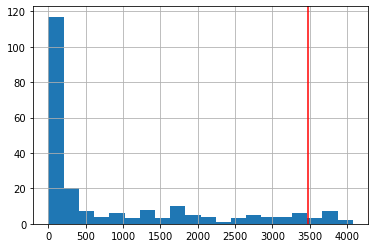

In [6]:
unq = np.array([len(np.unique(data[:, x])) for x in range(data.shape[1])])
keepUnique = np.where(unq > n_clusters* 2.5)[0]
print(f"keepUnique {len(keepUnique)}")
data = data[:, keepUnique]
data.shape

data = pd.DataFrame(data)

data = data[data ==0]

data = data.replace(0, 1)

data = data.fillna(0)

zeros = data.sum(axis = 0)


threshold = np.percentile(zeros.values, 95)

keepZeros = np.where(zeros.values < threshold)[0]
print(f"keepZeros {len(keepZeros)}")
zeros.hist(bins = 20)
plt.axvline(threshold , c = "red")

In [7]:
data = np.array(data_mat['X'])

data = data[:, keepUnique]
data = data[:, keepZeros]

data = preprocessing.MinMaxScaler().fit_transform(data)
data.shape

(4271, 210)

In [8]:
meta_features = feature_ranking.rank_features(data,
                                              nb_bins=20,
                                              rank_threshold=90,
                                              z_file=None,
                                              metric='correlation',
                                              redundant_threshold=0.3)

*** Computing 1D feature ranking ...
Dispersion tests took 4.63 sec
Entropy computation 1.39 sec
KNN computation 0.16 sec
Sorting and thresholds 0.02 sec
Performing hierarchical clustering...
Hierarchical clustering 0.1 sec
Handle redundant features 0.05 sec
Returning 77 redundant features and  6 important features


In [9]:
model_file = "models/gmm_arl.h5"
gmm_arl_population, n = features_2d.run(data,
                                n_clusters,
                                meta_features,
                                model_file=model_file,
                                theta=0.07,
                                add_close_population=True,
                                exploration_factor = 5)
print(gmm_arl_population.shape, n)

*** Exploring 2D feature space with NN ...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


trimming 156 to 66
handle_close_important (66, 3), total 222, 0.07825642824172974
relevant_features 54 => computing 449 
trimming 306 to 77
handle_important_features (143, 3),  total 585, 0.07929255068302155
irrelevant_features 79 => computing 362
trimming 116 to 66
handle_not_important_features (209, 3), total 419, 0.07929255068302155
handle_all_features 133 => computing 634
trimming 266 to 133
handle_all_features (342, 3),  total 778, 0.08009588718414307
Returning (342, 3), explored a total of 2004 feature pairs
(342, 4) 2004


In [10]:
globalResults = {}

In [12]:
method = "adapted_ratkowsky_lance"
threshold=0.09#
score_tolerance=0.009
clustering = "gmm"

round_size = 3
debug = False
ignore_redundant= True
epochs = 10*round_size

sampling = {
    "ARCHIVE2D": { 
        "ga": 0.3,
        "max": 0.3 },
    "CLOSE": { 
        "ga": 0.4,
        "max": 0.4 },
    "IMP1D": { 
        "ga": 0.2,
        "max": 0.2 },
    "RANDOM": { 
        "ga": 0.1,
        "max": 0.1},
}
params = ga.ga_parameters(
    n_clusters,
    data.shape[1],
    truth,
    meta_features,
    method=method,
    truth_methods=['ari'],
    archive_2d=gmm_arl_population[gmm_arl_population["pred"] > threshold].iloc[:4000],
    debug=debug,
    epochs=epochs,
    round_size=round_size,
    sampling = sampling,
    ignore_redundant = ignore_redundant,
    allow_subspace_overlap = False,
    improvement_per_mutation_report = True,
    score_tolerance=score_tolerance,
    clustering = clustering,
    total_maximisation_exploration = 300,
    max_subspace_size = 100,
    min_cluster_size = 90,
    pca = False

)
print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])
params

solutions, archive= ga.run(data, params)
display(solutions)
globalResults[f"{clustering}_{method}"] = solutions
solutions.to_pickle(f"data/{filename}_{clustering}_{method}.pkl")

  0%|          | 0/31 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 133, orig size 210, nb imp : 6
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [30 40 20 10] [0.3, 0.4, 0.2, 0.1]
adding 50 random population


 10%|▉         | 3/31 [02:52<26:06, 55.96s/it]

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.074434,0.24,"[0, 1, 2, 4, 6, 8, 17, 21, 23, 27, 28, 29, 32,...","[5, 1, 5, 3, 0, 0, 5, 4, 3, 2, 3, 6, 0, 2, 4, ...",54.0,"Counter({0: 1050, 3: 1023, 6: 701, 5: 469, 1: ..."


adding 17 random population


 19%|█▉        | 6/31 [13:15<50:48, 121.92s/it]  

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.074434,0.24,"[0, 1, 2, 4, 6, 8, 17, 21, 23, 27, 28, 29, 32,...","[5, 1, 5, 3, 0, 0, 5, 4, 3, 2, 3, 6, 0, 2, 4, ...",54.0,"Counter({0: 1050, 3: 1023, 6: 701, 5: 469, 1: ..."
1,0.074804,0.50,"[9, 11, 15, 16, 50, 58, 60, 61, 62, 63, 64, 77...","[1, 1, 1, 3, 3, 3, 5, 4, 0, 4, 0, 3, 7, 7, 4, ...",16.0,"Counter({3: 1608, 7: 809, 0: 564, 1: 478, 2: 4..."


adding 8 random population


 29%|██▉       | 9/31 [17:24<33:30, 91.38s/it] 

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.074434,0.24,"[0, 1, 2, 4, 6, 8, 17, 21, 23, 27, 28, 29, 32,...","[5, 1, 5, 3, 0, 0, 5, 4, 3, 2, 3, 6, 0, 2, 4, ...",54.0,"Counter({0: 1050, 3: 1023, 6: 701, 5: 469, 1: ..."
1,0.074804,0.50,"[9, 11, 15, 16, 50, 58, 60, 61, 62, 63, 64, 77...","[1, 1, 1, 3, 3, 3, 5, 4, 0, 4, 0, 3, 7, 7, 4, ...",16.0,"Counter({3: 1608, 7: 809, 0: 564, 1: 478, 2: 4..."
2,0.069469,0.27,"[37, 56, 69, 70, 75, 80, 82, 101, 102, 134, 13...","[2, 7, 2, 5, 5, 1, 2, 3, 5, 4, 5, 1, 0, 6, 3, ...",25.0,"Counter({5: 1025, 0: 994, 1: 676, 7: 583, 4: 3..."


adding 25 random population


 39%|███▊      | 12/31 [21:44<27:22, 86.44s/it] 

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.074434,0.24,"[0, 1, 2, 4, 6, 8, 17, 21, 23, 27, 28, 29, 32,...","[5, 1, 5, 3, 0, 0, 5, 4, 3, 2, 3, 6, 0, 2, 4, ...",54.0,"Counter({0: 1050, 3: 1023, 6: 701, 5: 469, 1: ..."
1,0.074804,0.50,"[9, 11, 15, 16, 50, 58, 60, 61, 62, 63, 64, 77...","[1, 1, 1, 3, 3, 3, 5, 4, 0, 4, 0, 3, 7, 7, 4, ...",16.0,"Counter({3: 1608, 7: 809, 0: 564, 1: 478, 2: 4..."
2,0.069469,0.27,"[37, 56, 69, 70, 75, 80, 82, 101, 102, 134, 13...","[2, 7, 2, 5, 5, 1, 2, 3, 5, 4, 5, 1, 0, 6, 3, ...",25.0,"Counter({5: 1025, 0: 994, 1: 676, 7: 583, 4: 3..."
3,0.068998,0.45,"[5, 14, 20, 22, 48, 65, 71, 76, 95, 104, 107, ...","[3, 3, 3, 5, 0, 5, 6, 4, 7, 4, 7, 5, 5, 0, 4, ...",17.0,"Counter({5: 1864, 0: 555, 7: 548, 3: 514, 1: 3..."


adding 34 random population


 48%|████▊     | 15/31 [24:54<17:33, 65.86s/it]

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.074434,0.24,"[0, 1, 2, 4, 6, 8, 17, 21, 23, 27, 28, 29, 32,...","[5, 1, 5, 3, 0, 0, 5, 4, 3, 2, 3, 6, 0, 2, 4, ...",54.0,"Counter({0: 1050, 3: 1023, 6: 701, 5: 469, 1: ..."
1,0.074804,0.50,"[9, 11, 15, 16, 50, 58, 60, 61, 62, 63, 64, 77...","[1, 1, 1, 3, 3, 3, 5, 4, 0, 4, 0, 3, 7, 7, 4, ...",16.0,"Counter({3: 1608, 7: 809, 0: 564, 1: 478, 2: 4..."
2,0.069469,0.27,"[37, 56, 69, 70, 75, 80, 82, 101, 102, 134, 13...","[2, 7, 2, 5, 5, 1, 2, 3, 5, 4, 5, 1, 0, 6, 3, ...",25.0,"Counter({5: 1025, 0: 994, 1: 676, 7: 583, 4: 3..."
3,0.068998,0.45,"[5, 14, 20, 22, 48, 65, 71, 76, 95, 104, 107, ...","[3, 3, 3, 5, 0, 5, 6, 4, 7, 4, 7, 5, 5, 0, 4, ...",17.0,"Counter({5: 1864, 0: 555, 7: 548, 3: 514, 1: 3..."
4,0.062178,0.16,"[3, 103, 122, 130, 146, 158, 162, 163, 171, 17...","[1, 7, 1, 1, 5, 0, 1, 2, 5, 6, 5, 4, 0, 3, 2, ...",15.0,"Counter({5: 851, 0: 806, 7: 785, 1: 595, 4: 54..."


adding 14 random population


 58%|█████▊    | 18/31 [28:05<13:46, 63.58s/it]

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.074434,0.24,"[0, 1, 2, 4, 6, 8, 17, 21, 23, 27, 28, 29, 32,...","[5, 1, 5, 3, 0, 0, 5, 4, 3, 2, 3, 6, 0, 2, 4, ...",54.0,"Counter({0: 1050, 3: 1023, 6: 701, 5: 469, 1: ..."
1,0.074804,0.50,"[9, 11, 15, 16, 50, 58, 60, 61, 62, 63, 64, 77...","[1, 1, 1, 3, 3, 3, 5, 4, 0, 4, 0, 3, 7, 7, 4, ...",16.0,"Counter({3: 1608, 7: 809, 0: 564, 1: 478, 2: 4..."
2,0.069469,0.27,"[37, 56, 69, 70, 75, 80, 82, 101, 102, 134, 13...","[2, 7, 2, 5, 5, 1, 2, 3, 5, 4, 5, 1, 0, 6, 3, ...",25.0,"Counter({5: 1025, 0: 994, 1: 676, 7: 583, 4: 3..."
3,0.068998,0.45,"[5, 14, 20, 22, 48, 65, 71, 76, 95, 104, 107, ...","[3, 3, 3, 5, 0, 5, 6, 4, 7, 4, 7, 5, 5, 0, 4, ...",17.0,"Counter({5: 1864, 0: 555, 7: 548, 3: 514, 1: 3..."
4,0.062178,0.16,"[3, 103, 122, 130, 146, 158, 162, 163, 171, 17...","[1, 7, 1, 1, 5, 0, 1, 2, 5, 6, 5, 4, 0, 3, 2, ...",15.0,"Counter({5: 851, 0: 806, 7: 785, 1: 595, 4: 54..."
5,0.061966,0.14,"[7, 10, 72, 116, 129, 141, 150]","[1, 5, 5, 1, 1, 1, 1, 7, 3, 2, 3, 5, 1, 0, 7, ...",7.0,"Counter({1: 1029, 3: 927, 5: 736, 4: 525, 0: 4..."


adding 21 random population


 68%|██████▊   | 21/31 [29:50<07:14, 43.47s/it]

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.074434,0.24,"[0, 1, 2, 4, 6, 8, 17, 21, 23, 27, 28, 29, 32,...","[5, 1, 5, 3, 0, 0, 5, 4, 3, 2, 3, 6, 0, 2, 4, ...",54.0,"Counter({0: 1050, 3: 1023, 6: 701, 5: 469, 1: ..."
1,0.074804,0.50,"[9, 11, 15, 16, 50, 58, 60, 61, 62, 63, 64, 77...","[1, 1, 1, 3, 3, 3, 5, 4, 0, 4, 0, 3, 7, 7, 4, ...",16.0,"Counter({3: 1608, 7: 809, 0: 564, 1: 478, 2: 4..."
2,0.069469,0.27,"[37, 56, 69, 70, 75, 80, 82, 101, 102, 134, 13...","[2, 7, 2, 5, 5, 1, 2, 3, 5, 4, 5, 1, 0, 6, 3, ...",25.0,"Counter({5: 1025, 0: 994, 1: 676, 7: 583, 4: 3..."
3,0.068998,0.45,"[5, 14, 20, 22, 48, 65, 71, 76, 95, 104, 107, ...","[3, 3, 3, 5, 0, 5, 6, 4, 7, 4, 7, 5, 5, 0, 4, ...",17.0,"Counter({5: 1864, 0: 555, 7: 548, 3: 514, 1: 3..."
4,0.062178,0.16,"[3, 103, 122, 130, 146, 158, 162, 163, 171, 17...","[1, 7, 1, 1, 5, 0, 1, 2, 5, 6, 5, 4, 0, 3, 2, ...",15.0,"Counter({5: 851, 0: 806, 7: 785, 1: 595, 4: 54..."
5,0.061966,0.14,"[7, 10, 72, 116, 129, 141, 150]","[1, 5, 5, 1, 1, 1, 1, 7, 3, 2, 3, 5, 1, 0, 7, ...",7.0,"Counter({1: 1029, 3: 927, 5: 736, 4: 525, 0: 4..."
6,0.061858,0.28,"[30, 34, 38, 52, 53, 121, 124, 142, 165, 170, ...","[1, 4, 1, 0, 4, 6, 1, 2, 4, 2, 0, 6, 6, 5, 2, ...",11.0,"Counter({6: 983, 0: 942, 3: 707, 4: 512, 1: 34..."


adding 21 random population


 77%|███████▋  | 24/31 [31:37<04:16, 36.71s/it]

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.074434,0.24,"[0, 1, 2, 4, 6, 8, 17, 21, 23, 27, 28, 29, 32,...","[5, 1, 5, 3, 0, 0, 5, 4, 3, 2, 3, 6, 0, 2, 4, ...",54.0,"Counter({0: 1050, 3: 1023, 6: 701, 5: 469, 1: ..."
1,0.074804,0.50,"[9, 11, 15, 16, 50, 58, 60, 61, 62, 63, 64, 77...","[1, 1, 1, 3, 3, 3, 5, 4, 0, 4, 0, 3, 7, 7, 4, ...",16.0,"Counter({3: 1608, 7: 809, 0: 564, 1: 478, 2: 4..."
2,0.069469,0.27,"[37, 56, 69, 70, 75, 80, 82, 101, 102, 134, 13...","[2, 7, 2, 5, 5, 1, 2, 3, 5, 4, 5, 1, 0, 6, 3, ...",25.0,"Counter({5: 1025, 0: 994, 1: 676, 7: 583, 4: 3..."
3,0.068998,0.45,"[5, 14, 20, 22, 48, 65, 71, 76, 95, 104, 107, ...","[3, 3, 3, 5, 0, 5, 6, 4, 7, 4, 7, 5, 5, 0, 4, ...",17.0,"Counter({5: 1864, 0: 555, 7: 548, 3: 514, 1: 3..."
4,0.062178,0.16,"[3, 103, 122, 130, 146, 158, 162, 163, 171, 17...","[1, 7, 1, 1, 5, 0, 1, 2, 5, 6, 5, 4, 0, 3, 2, ...",15.0,"Counter({5: 851, 0: 806, 7: 785, 1: 595, 4: 54..."
5,0.061966,0.14,"[7, 10, 72, 116, 129, 141, 150]","[1, 5, 5, 1, 1, 1, 1, 7, 3, 2, 3, 5, 1, 0, 7, ...",7.0,"Counter({1: 1029, 3: 927, 5: 736, 4: 525, 0: 4..."
6,0.061858,0.28,"[30, 34, 38, 52, 53, 121, 124, 142, 165, 170, ...","[1, 4, 1, 0, 4, 6, 1, 2, 4, 2, 0, 6, 6, 5, 2, ...",11.0,"Counter({6: 983, 0: 942, 3: 707, 4: 512, 1: 34..."
7,0.074079,0.10,"[128, 196]","[1, 1, 1, 0, 0, 2, 0, 7, 0, 7, 0, 5, 5, 0, 6, ...",2.0,"Counter({0: 2194, 5: 594, 1: 463, 4: 348, 2: 3..."


adding 9 random population


 87%|████████▋ | 27/31 [33:17<02:15, 33.83s/it]

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.074434,0.24,"[0, 1, 2, 4, 6, 8, 17, 21, 23, 27, 28, 29, 32,...","[5, 1, 5, 3, 0, 0, 5, 4, 3, 2, 3, 6, 0, 2, 4, ...",54.0,"Counter({0: 1050, 3: 1023, 6: 701, 5: 469, 1: ..."
1,0.074804,0.50,"[9, 11, 15, 16, 50, 58, 60, 61, 62, 63, 64, 77...","[1, 1, 1, 3, 3, 3, 5, 4, 0, 4, 0, 3, 7, 7, 4, ...",16.0,"Counter({3: 1608, 7: 809, 0: 564, 1: 478, 2: 4..."
2,0.069469,0.27,"[37, 56, 69, 70, 75, 80, 82, 101, 102, 134, 13...","[2, 7, 2, 5, 5, 1, 2, 3, 5, 4, 5, 1, 0, 6, 3, ...",25.0,"Counter({5: 1025, 0: 994, 1: 676, 7: 583, 4: 3..."
3,0.068998,0.45,"[5, 14, 20, 22, 48, 65, 71, 76, 95, 104, 107, ...","[3, 3, 3, 5, 0, 5, 6, 4, 7, 4, 7, 5, 5, 0, 4, ...",17.0,"Counter({5: 1864, 0: 555, 7: 548, 3: 514, 1: 3..."
4,0.062178,0.16,"[3, 103, 122, 130, 146, 158, 162, 163, 171, 17...","[1, 7, 1, 1, 5, 0, 1, 2, 5, 6, 5, 4, 0, 3, 2, ...",15.0,"Counter({5: 851, 0: 806, 7: 785, 1: 595, 4: 54..."
5,0.061966,0.14,"[7, 10, 72, 116, 129, 141, 150]","[1, 5, 5, 1, 1, 1, 1, 7, 3, 2, 3, 5, 1, 0, 7, ...",7.0,"Counter({1: 1029, 3: 927, 5: 736, 4: 525, 0: 4..."
6,0.061858,0.28,"[30, 34, 38, 52, 53, 121, 124, 142, 165, 170, ...","[1, 4, 1, 0, 4, 6, 1, 2, 4, 2, 0, 6, 6, 5, 2, ...",11.0,"Counter({6: 983, 0: 942, 3: 707, 4: 512, 1: 34..."
7,0.074079,0.10,"[128, 196]","[1, 1, 1, 0, 0, 2, 0, 7, 0, 7, 0, 5, 5, 0, 6, ...",2.0,"Counter({0: 2194, 5: 594, 1: 463, 4: 348, 2: 3..."
8,0.060890,0.08,"[24, 31, 45, 84, 87, 115, 131, 145, 152, 180]","[7, 1, 7, 7, 3, 3, 7, 4, 3, 5, 3, 2, 3, 5, 4, ...",10.0,"Counter({3: 1044, 7: 828, 1: 674, 0: 514, 2: 4..."


adding 26 random population


 97%|█████████▋| 30/31 [35:08<00:34, 34.46s/it]

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.074434,0.24,"[0, 1, 2, 4, 6, 8, 17, 21, 23, 27, 28, 29, 32,...","[5, 1, 5, 3, 0, 0, 5, 4, 3, 2, 3, 6, 0, 2, 4, ...",54.0,"Counter({0: 1050, 3: 1023, 6: 701, 5: 469, 1: ..."
1,0.074804,0.50,"[9, 11, 15, 16, 50, 58, 60, 61, 62, 63, 64, 77...","[1, 1, 1, 3, 3, 3, 5, 4, 0, 4, 0, 3, 7, 7, 4, ...",16.0,"Counter({3: 1608, 7: 809, 0: 564, 1: 478, 2: 4..."
2,0.069469,0.27,"[37, 56, 69, 70, 75, 80, 82, 101, 102, 134, 13...","[2, 7, 2, 5, 5, 1, 2, 3, 5, 4, 5, 1, 0, 6, 3, ...",25.0,"Counter({5: 1025, 0: 994, 1: 676, 7: 583, 4: 3..."
3,0.068998,0.45,"[5, 14, 20, 22, 48, 65, 71, 76, 95, 104, 107, ...","[3, 3, 3, 5, 0, 5, 6, 4, 7, 4, 7, 5, 5, 0, 4, ...",17.0,"Counter({5: 1864, 0: 555, 7: 548, 3: 514, 1: 3..."
4,0.062178,0.16,"[3, 103, 122, 130, 146, 158, 162, 163, 171, 17...","[1, 7, 1, 1, 5, 0, 1, 2, 5, 6, 5, 4, 0, 3, 2, ...",15.0,"Counter({5: 851, 0: 806, 7: 785, 1: 595, 4: 54..."
5,0.061966,0.14,"[7, 10, 72, 116, 129, 141, 150]","[1, 5, 5, 1, 1, 1, 1, 7, 3, 2, 3, 5, 1, 0, 7, ...",7.0,"Counter({1: 1029, 3: 927, 5: 736, 4: 525, 0: 4..."
6,0.061858,0.28,"[30, 34, 38, 52, 53, 121, 124, 142, 165, 170, ...","[1, 4, 1, 0, 4, 6, 1, 2, 4, 2, 0, 6, 6, 5, 2, ...",11.0,"Counter({6: 983, 0: 942, 3: 707, 4: 512, 1: 34..."
7,0.074079,0.10,"[128, 196]","[1, 1, 1, 0, 0, 2, 0, 7, 0, 7, 0, 5, 5, 0, 6, ...",2.0,"Counter({0: 2194, 5: 594, 1: 463, 4: 348, 2: 3..."
8,0.060890,0.08,"[24, 31, 45, 84, 87, 115, 131, 145, 152, 180]","[7, 1, 7, 7, 3, 3, 7, 4, 3, 5, 3, 2, 3, 5, 4, ...",10.0,"Counter({3: 1044, 7: 828, 1: 674, 0: 514, 2: 4..."
9,0.061521,0.15,"[41, 117, 192]","[0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, ...",3.0,"Counter({0: 2867, 7: 360, 3: 249, 5: 229, 6: 2..."


adding 5 random population


100%|██████████| 31/31 [35:47<00:00, 69.27s/it]


,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.074434,0.24,"[0, 1, 2, 4, 6, 8, 17, 21, 23, 27, 28, 29, 32,...","[5, 1, 5, 3, 0, 0, 5, 4, 3, 2, 3, 6, 0, 2, 4, ...",54.0,"Counter({0: 1050, 3: 1023, 6: 701, 5: 469, 1: ..."
1,0.074804,0.50,"[9, 11, 15, 16, 50, 58, 60, 61, 62, 63, 64, 77...","[1, 1, 1, 3, 3, 3, 5, 4, 0, 4, 0, 3, 7, 7, 4, ...",16.0,"Counter({3: 1608, 7: 809, 0: 564, 1: 478, 2: 4..."
2,0.069469,0.27,"[37, 56, 69, 70, 75, 80, 82, 101, 102, 134, 13...","[2, 7, 2, 5, 5, 1, 2, 3, 5, 4, 5, 1, 0, 6, 3, ...",25.0,"Counter({5: 1025, 0: 994, 1: 676, 7: 583, 4: 3..."
3,0.068998,0.45,"[5, 14, 20, 22, 48, 65, 71, 76, 95, 104, 107, ...","[3, 3, 3, 5, 0, 5, 6, 4, 7, 4, 7, 5, 5, 0, 4, ...",17.0,"Counter({5: 1864, 0: 555, 7: 548, 3: 514, 1: 3..."
4,0.062178,0.16,"[3, 103, 122, 130, 146, 158, 162, 163, 171, 17...","[1, 7, 1, 1, 5, 0, 1, 2, 5, 6, 5, 4, 0, 3, 2, ...",15.0,"Counter({5: 851, 0: 806, 7: 785, 1: 595, 4: 54..."
5,0.061966,0.14,"[7, 10, 72, 116, 129, 141, 150]","[1, 5, 5, 1, 1, 1, 1, 7, 3, 2, 3, 5, 1, 0, 7, ...",7.0,"Counter({1: 1029, 3: 927, 5: 736, 4: 525, 0: 4..."
6,0.061858,0.28,"[30, 34, 38, 52, 53, 121, 124, 142, 165, 170, ...","[1, 4, 1, 0, 4, 6, 1, 2, 4, 2, 0, 6, 6, 5, 2, ...",11.0,"Counter({6: 983, 0: 942, 3: 707, 4: 512, 1: 34..."
7,0.074079,0.10,"[128, 196]","[1, 1, 1, 0, 0, 2, 0, 7, 0, 7, 0, 5, 5, 0, 6, ...",2.0,"Counter({0: 2194, 5: 594, 1: 463, 4: 348, 2: 3..."
8,0.060890,0.08,"[24, 31, 45, 84, 87, 115, 131, 145, 152, 180]","[7, 1, 7, 7, 3, 3, 7, 4, 3, 5, 3, 2, 3, 5, 4, ...",10.0,"Counter({3: 1044, 7: 828, 1: 674, 0: 514, 2: 4..."
9,0.061521,0.15,"[41, 117, 192]","[0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, ...",3.0,"Counter({0: 2867, 7: 360, 3: 249, 5: 229, 6: 2..."


In [13]:
method = "adapted_silhouette"
threshold=0.09#0.3,#
score_tolerance=0.009
clustering = "hdbscan"

round_size = 3
debug = False
ignore_redundant= True
epochs = 10*round_size

sampling = {
    "ARCHIVE2D": { 
        "ga": 0.3,
        "max": 0.3 },
    "CLOSE": { 
        "ga": 0.4,
        "max": 0.4 },
    "IMP1D": { 
        "ga": 0.2,
        "max": 0.2 },
    "RANDOM": { 
        "ga": 0.1,
        "max": 0.1},
}
params = ga.ga_parameters(
    n_clusters,
    data.shape[1],
    truth,
    meta_features,
    method=method,
    truth_methods=['ari'],
    archive_2d=gmm_arl_population[gmm_arl_population["pred"] > threshold].iloc[:4000],
    debug=debug,
    epochs=epochs,
    round_size=round_size,
    sampling = sampling,
    ignore_redundant = ignore_redundant,
    allow_subspace_overlap = False,
    improvement_per_mutation_report = True,
    score_tolerance=score_tolerance,
    clustering = clustering,
    total_maximisation_exploration = 150,
    max_subspace_size = 40,
    maximisation_size = 50,
    pca = False,
    hdbscan_min_cluster_size =100

)
print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])
params

solutions, archive= ga.run(data, params)
solutions.to_pickle(f"data/{filename}_{clustering}_{method}.pkl")
display(solutions)
globalResults[f"{clustering}_{method}"] = solutions

  0%|          | 0/31 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 133, orig size 210, nb imp : 6
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [15 20 10  5] [0.3, 0.4, 0.2, 0.1]
adding 50 random population


 10%|▉         | 3/31 [03:54<35:15, 75.56s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.533101,0.17,"[97, 143]","[2, 5, 4, 5, 5, 2, 2, -1, 5, -1, 5, -1, 5, 2, ...",2.0,"Counter({5: 2136, 2: 736, -1: 505, 1: 348, 4: ..."


adding 4 random population


 19%|█▉        | 6/31 [06:53<26:34, 63.80s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.533101,0.17,"[97, 143]","[2, 5, 4, 5, 5, 2, 2, -1, 5, -1, 5, -1, 5, 2, ...",2.0,"Counter({5: 2136, 2: 736, -1: 505, 1: 348, 4: ..."
1,0.585321,0.15,"[26, 140, 164, 185]","[4, 2, 3, 3, 4, 4, 0, 4, -1, -1, -1, 4, 4, 4, ...",4.0,"Counter({4: 2218, -1: 823, 3: 397, 2: 365, 1: ..."


adding 3 random population


 29%|██▉       | 9/31 [10:12<22:45, 62.05s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.533101,0.17,"[97, 143]","[2, 5, 4, 5, 5, 2, 2, -1, 5, -1, 5, -1, 5, 2, ...",2.0,"Counter({5: 2136, 2: 736, -1: 505, 1: 348, 4: ..."
1,0.585321,0.15,"[26, 140, 164, 185]","[4, 2, 3, 3, 4, 4, 0, 4, -1, -1, -1, 4, 4, 4, ...",4.0,"Counter({4: 2218, -1: 823, 3: 397, 2: 365, 1: ..."
2,0.527105,0.20,"[12, 13, 18, 95]","[-1, -1, -1, 4, -1, 4, 2, -1, 6, -1, 6, 2, 6, ...",4.0,"Counter({-1: 1153, 4: 1073, 6: 876, 5: 370, 1:..."


adding 7 random population


 39%|███▊      | 12/31 [14:32<24:22, 76.97s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.533101,0.17,"[97, 143]","[2, 5, 4, 5, 5, 2, 2, -1, 5, -1, 5, -1, 5, 2, ...",2.0,"Counter({5: 2136, 2: 736, -1: 505, 1: 348, 4: ..."
1,0.585321,0.15,"[26, 140, 164, 185]","[4, 2, 3, 3, 4, 4, 0, 4, -1, -1, -1, 4, 4, 4, ...",4.0,"Counter({4: 2218, -1: 823, 3: 397, 2: 365, 1: ..."
2,0.527105,0.20,"[12, 13, 18, 95]","[-1, -1, -1, 4, -1, 4, 2, -1, 6, -1, 6, 2, 6, ...",4.0,"Counter({-1: 1153, 4: 1073, 6: 876, 5: 370, 1:..."
3,0.559380,0.15,"[91, 196]","[3, 0, 3, 7, 6, 7, 6, 1, 6, 0, 6, 6, 6, 5, -1,...",2.0,"Counter({6: 2186, 7: 680, 2: 344, -1: 303, 5: ..."


adding 10 random population


 48%|████▊     | 15/31 [17:42<17:39, 66.22s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.533101,0.17,"[97, 143]","[2, 5, 4, 5, 5, 2, 2, -1, 5, -1, 5, -1, 5, 2, ...",2.0,"Counter({5: 2136, 2: 736, -1: 505, 1: 348, 4: ..."
1,0.585321,0.15,"[26, 140, 164, 185]","[4, 2, 3, 3, 4, 4, 0, 4, -1, -1, -1, 4, 4, 4, ...",4.0,"Counter({4: 2218, -1: 823, 3: 397, 2: 365, 1: ..."
2,0.527105,0.20,"[12, 13, 18, 95]","[-1, -1, -1, 4, -1, 4, 2, -1, 6, -1, 6, 2, 6, ...",4.0,"Counter({-1: 1153, 4: 1073, 6: 876, 5: 370, 1:..."
3,0.559380,0.15,"[91, 196]","[3, 0, 3, 7, 6, 7, 6, 1, 6, 0, 6, 6, 6, 5, -1,...",2.0,"Counter({6: 2186, 7: 680, 2: 344, -1: 303, 5: ..."
4,0.512305,0.04,"[25, 45]","[9, 4, 8, 10, 6, 10, 8, -1, 9, 2, 3, 6, 3, 0, ...",2.0,"Counter({7: 607, 10: 599, 6: 557, 3: 490, -1: ..."


adding 5 random population


 58%|█████▊    | 18/31 [20:12<11:38, 53.73s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.533101,0.17,"[97, 143]","[2, 5, 4, 5, 5, 2, 2, -1, 5, -1, 5, -1, 5, 2, ...",2.0,"Counter({5: 2136, 2: 736, -1: 505, 1: 348, 4: ..."
1,0.585321,0.15,"[26, 140, 164, 185]","[4, 2, 3, 3, 4, 4, 0, 4, -1, -1, -1, 4, 4, 4, ...",4.0,"Counter({4: 2218, -1: 823, 3: 397, 2: 365, 1: ..."
2,0.527105,0.20,"[12, 13, 18, 95]","[-1, -1, -1, 4, -1, 4, 2, -1, 6, -1, 6, 2, 6, ...",4.0,"Counter({-1: 1153, 4: 1073, 6: 876, 5: 370, 1:..."
3,0.559380,0.15,"[91, 196]","[3, 0, 3, 7, 6, 7, 6, 1, 6, 0, 6, 6, 6, 5, -1,...",2.0,"Counter({6: 2186, 7: 680, 2: 344, -1: 303, 5: ..."
4,0.512305,0.04,"[25, 45]","[9, 4, 8, 10, 6, 10, 8, -1, 9, 2, 3, 6, 3, 0, ...",2.0,"Counter({7: 607, 10: 599, 6: 557, 3: 490, -1: ..."
5,0.511520,0.07,"[153, 186]","[7, 6, 6, 2, 7, 3, -1, -1, 5, -1, 5, 5, 5, 1, ...",2.0,"Counter({6: 928, 1: 854, 7: 644, 2: 557, -1: 3..."


adding 9 random population


 68%|██████▊   | 21/31 [22:39<08:09, 48.99s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.533101,0.17,"[97, 143]","[2, 5, 4, 5, 5, 2, 2, -1, 5, -1, 5, -1, 5, 2, ...",2.0,"Counter({5: 2136, 2: 736, -1: 505, 1: 348, 4: ..."
1,0.585321,0.15,"[26, 140, 164, 185]","[4, 2, 3, 3, 4, 4, 0, 4, -1, -1, -1, 4, 4, 4, ...",4.0,"Counter({4: 2218, -1: 823, 3: 397, 2: 365, 1: ..."
2,0.527105,0.20,"[12, 13, 18, 95]","[-1, -1, -1, 4, -1, 4, 2, -1, 6, -1, 6, 2, 6, ...",4.0,"Counter({-1: 1153, 4: 1073, 6: 876, 5: 370, 1:..."
3,0.559380,0.15,"[91, 196]","[3, 0, 3, 7, 6, 7, 6, 1, 6, 0, 6, 6, 6, 5, -1,...",2.0,"Counter({6: 2186, 7: 680, 2: 344, -1: 303, 5: ..."
4,0.512305,0.04,"[25, 45]","[9, 4, 8, 10, 6, 10, 8, -1, 9, 2, 3, 6, 3, 0, ...",2.0,"Counter({7: 607, 10: 599, 6: 557, 3: 490, -1: ..."
5,0.511520,0.07,"[153, 186]","[7, 6, 6, 2, 7, 3, -1, -1, 5, -1, 5, 5, 5, 1, ...",2.0,"Counter({6: 928, 1: 854, 7: 644, 2: 557, -1: 3..."
6,0.468951,0.08,"[4, 138]","[3, 8, 9, 2, 7, 5, 9, -1, 1, -1, 6, 4, 2, 1, -...",2.0,"Counter({2: 789, 4: 738, -1: 650, 5: 401, 8: 3..."


adding 2 random population


 77%|███████▋  | 24/31 [25:02<05:23, 46.27s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.533101,0.17,"[97, 143]","[2, 5, 4, 5, 5, 2, 2, -1, 5, -1, 5, -1, 5, 2, ...",2.0,"Counter({5: 2136, 2: 736, -1: 505, 1: 348, 4: ..."
1,0.585321,0.15,"[26, 140, 164, 185]","[4, 2, 3, 3, 4, 4, 0, 4, -1, -1, -1, 4, 4, 4, ...",4.0,"Counter({4: 2218, -1: 823, 3: 397, 2: 365, 1: ..."
2,0.527105,0.20,"[12, 13, 18, 95]","[-1, -1, -1, 4, -1, 4, 2, -1, 6, -1, 6, 2, 6, ...",4.0,"Counter({-1: 1153, 4: 1073, 6: 876, 5: 370, 1:..."
3,0.559380,0.15,"[91, 196]","[3, 0, 3, 7, 6, 7, 6, 1, 6, 0, 6, 6, 6, 5, -1,...",2.0,"Counter({6: 2186, 7: 680, 2: 344, -1: 303, 5: ..."
4,0.512305,0.04,"[25, 45]","[9, 4, 8, 10, 6, 10, 8, -1, 9, 2, 3, 6, 3, 0, ...",2.0,"Counter({7: 607, 10: 599, 6: 557, 3: 490, -1: ..."
5,0.511520,0.07,"[153, 186]","[7, 6, 6, 2, 7, 3, -1, -1, 5, -1, 5, 5, 5, 1, ...",2.0,"Counter({6: 928, 1: 854, 7: 644, 2: 557, -1: 3..."
6,0.468951,0.08,"[4, 138]","[3, 8, 9, 2, 7, 5, 9, -1, 1, -1, 6, 4, 2, 1, -...",2.0,"Counter({2: 789, 4: 738, -1: 650, 5: 401, 8: 3..."
7,0.437196,0.21,"[11, 117]","[6, 1, 4, -1, 9, 9, 6, 1, 7, -1, 9, 9, 6, -1, ...",2.0,"Counter({9: 1606, -1: 887, 7: 577, 5: 273, 6: ..."


adding 3 random population


 87%|████████▋ | 27/31 [27:34<03:11, 47.93s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.533101,0.17,"[97, 143]","[2, 5, 4, 5, 5, 2, 2, -1, 5, -1, 5, -1, 5, 2, ...",2.0,"Counter({5: 2136, 2: 736, -1: 505, 1: 348, 4: ..."
1,0.585321,0.15,"[26, 140, 164, 185]","[4, 2, 3, 3, 4, 4, 0, 4, -1, -1, -1, 4, 4, 4, ...",4.0,"Counter({4: 2218, -1: 823, 3: 397, 2: 365, 1: ..."
2,0.527105,0.20,"[12, 13, 18, 95]","[-1, -1, -1, 4, -1, 4, 2, -1, 6, -1, 6, 2, 6, ...",4.0,"Counter({-1: 1153, 4: 1073, 6: 876, 5: 370, 1:..."
3,0.559380,0.15,"[91, 196]","[3, 0, 3, 7, 6, 7, 6, 1, 6, 0, 6, 6, 6, 5, -1,...",2.0,"Counter({6: 2186, 7: 680, 2: 344, -1: 303, 5: ..."
4,0.512305,0.04,"[25, 45]","[9, 4, 8, 10, 6, 10, 8, -1, 9, 2, 3, 6, 3, 0, ...",2.0,"Counter({7: 607, 10: 599, 6: 557, 3: 490, -1: ..."
5,0.511520,0.07,"[153, 186]","[7, 6, 6, 2, 7, 3, -1, -1, 5, -1, 5, 5, 5, 1, ...",2.0,"Counter({6: 928, 1: 854, 7: 644, 2: 557, -1: 3..."
6,0.468951,0.08,"[4, 138]","[3, 8, 9, 2, 7, 5, 9, -1, 1, -1, 6, 4, 2, 1, -...",2.0,"Counter({2: 789, 4: 738, -1: 650, 5: 401, 8: 3..."
7,0.437196,0.21,"[11, 117]","[6, 1, 4, -1, 9, 9, 6, 1, 7, -1, 9, 9, 6, -1, ...",2.0,"Counter({9: 1606, -1: 887, 7: 577, 5: 273, 6: ..."
8,0.452699,0.19,"[90, 125, 126]","[-1, -1, -1, 4, 5, 2, -1, -1, 4, -1, 5, 6, 5, ...",3.0,"Counter({-1: 1283, 4: 765, 5: 504, 7: 449, 1: ..."


adding 12 random population


 97%|█████████▋| 30/31 [30:45<00:57, 57.83s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.533101,0.17,"[97, 143]","[2, 5, 4, 5, 5, 2, 2, -1, 5, -1, 5, -1, 5, 2, ...",2.0,"Counter({5: 2136, 2: 736, -1: 505, 1: 348, 4: ..."
1,0.585321,0.15,"[26, 140, 164, 185]","[4, 2, 3, 3, 4, 4, 0, 4, -1, -1, -1, 4, 4, 4, ...",4.0,"Counter({4: 2218, -1: 823, 3: 397, 2: 365, 1: ..."
2,0.527105,0.20,"[12, 13, 18, 95]","[-1, -1, -1, 4, -1, 4, 2, -1, 6, -1, 6, 2, 6, ...",4.0,"Counter({-1: 1153, 4: 1073, 6: 876, 5: 370, 1:..."
3,0.559380,0.15,"[91, 196]","[3, 0, 3, 7, 6, 7, 6, 1, 6, 0, 6, 6, 6, 5, -1,...",2.0,"Counter({6: 2186, 7: 680, 2: 344, -1: 303, 5: ..."
4,0.512305,0.04,"[25, 45]","[9, 4, 8, 10, 6, 10, 8, -1, 9, 2, 3, 6, 3, 0, ...",2.0,"Counter({7: 607, 10: 599, 6: 557, 3: 490, -1: ..."
5,0.511520,0.07,"[153, 186]","[7, 6, 6, 2, 7, 3, -1, -1, 5, -1, 5, 5, 5, 1, ...",2.0,"Counter({6: 928, 1: 854, 7: 644, 2: 557, -1: 3..."
6,0.468951,0.08,"[4, 138]","[3, 8, 9, 2, 7, 5, 9, -1, 1, -1, 6, 4, 2, 1, -...",2.0,"Counter({2: 789, 4: 738, -1: 650, 5: 401, 8: 3..."
7,0.437196,0.21,"[11, 117]","[6, 1, 4, -1, 9, 9, 6, 1, 7, -1, 9, 9, 6, -1, ...",2.0,"Counter({9: 1606, -1: 887, 7: 577, 5: 273, 6: ..."
8,0.452699,0.19,"[90, 125, 126]","[-1, -1, -1, 4, 5, 2, -1, -1, 4, -1, 5, 6, 5, ...",3.0,"Counter({-1: 1283, 4: 765, 5: 504, 7: 449, 1: ..."
9,0.426896,0.03,"[41, 72]","[12, 12, 14, 12, 3, 6, -1, -1, 0, -1, 1, 11, 3...",2.0,"Counter({-1: 848, 8: 484, 3: 438, 12: 325, 9: ..."


adding 3 random population


100%|██████████| 31/31 [32:00<00:00, 61.96s/it]


,adapted_silhouette,ari,features,partition,size,structure
0,0.533101,0.17,"[97, 143]","[2, 5, 4, 5, 5, 2, 2, -1, 5, -1, 5, -1, 5, 2, ...",2.0,"Counter({5: 2136, 2: 736, -1: 505, 1: 348, 4: ..."
1,0.585321,0.15,"[26, 140, 164, 185]","[4, 2, 3, 3, 4, 4, 0, 4, -1, -1, -1, 4, 4, 4, ...",4.0,"Counter({4: 2218, -1: 823, 3: 397, 2: 365, 1: ..."
2,0.527105,0.20,"[12, 13, 18, 95]","[-1, -1, -1, 4, -1, 4, 2, -1, 6, -1, 6, 2, 6, ...",4.0,"Counter({-1: 1153, 4: 1073, 6: 876, 5: 370, 1:..."
3,0.559380,0.15,"[91, 196]","[3, 0, 3, 7, 6, 7, 6, 1, 6, 0, 6, 6, 6, 5, -1,...",2.0,"Counter({6: 2186, 7: 680, 2: 344, -1: 303, 5: ..."
4,0.512305,0.04,"[25, 45]","[9, 4, 8, 10, 6, 10, 8, -1, 9, 2, 3, 6, 3, 0, ...",2.0,"Counter({7: 607, 10: 599, 6: 557, 3: 490, -1: ..."
5,0.511520,0.07,"[153, 186]","[7, 6, 6, 2, 7, 3, -1, -1, 5, -1, 5, 5, 5, 1, ...",2.0,"Counter({6: 928, 1: 854, 7: 644, 2: 557, -1: 3..."
6,0.468951,0.08,"[4, 138]","[3, 8, 9, 2, 7, 5, 9, -1, 1, -1, 6, 4, 2, 1, -...",2.0,"Counter({2: 789, 4: 738, -1: 650, 5: 401, 8: 3..."
7,0.437196,0.21,"[11, 117]","[6, 1, 4, -1, 9, 9, 6, 1, 7, -1, 9, 9, 6, -1, ...",2.0,"Counter({9: 1606, -1: 887, 7: 577, 5: 273, 6: ..."
8,0.452699,0.19,"[90, 125, 126]","[-1, -1, -1, 4, 5, 2, -1, -1, 4, -1, 5, 6, 5, ...",3.0,"Counter({-1: 1283, 4: 765, 5: 504, 7: 449, 1: ..."
9,0.426896,0.03,"[41, 72]","[12, 12, 14, 12, 3, 6, -1, -1, 0, -1, 1, 11, 3...",2.0,"Counter({-1: 848, 8: 484, 3: 438, 12: 325, 9: ..."


# Supervised analysis

In [9]:
from sklearn import mixture
import hdbscan

In [15]:
ranked_features = feature_ranking.supervised_feature_ranking(data, truth, 
                        nbTopFeatures = data.shape[1])
data = data[:, ranked_features]
imp_f = np.arange(50)

In [16]:
gmm_scores = []
hdbscan_scores = []
for i in range(2, 50):
    input_data = data[:, :i]
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    pred = gmm.fit_predict(input_data)
    ari = adjusted_rand_score(truth, pred)
    gmm_scores.append(ari)

    pred = hdbscan.HDBSCAN(min_cluster_size =2).fit(input_data).labels_
    ari = adjusted_rand_score(truth, pred)
    hdbscan_scores.append(ari)
print(f" GMM ari = {max(gmm_scores)}, {np.argmax(gmm_scores)}")
print(f" HDBSCAN ari = {max(hdbscan_scores)}, {np.argmax(hdbscan_scores)}")

 GMM ari = 0.7368845216965627, 39
 HDBSCAN ari = 0.18773783444444384, 0


In [10]:
from sklearn.feature_selection import chi2,  mutual_info_classif, SelectKBest
sel = SelectKBest(mutual_info_classif, k=50).fit_transform(data, truth)
gmm_scores = []
hdbscan_scores = []
for i in range(2, 50):
    input_data = sel[:, :i]
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    pred = gmm.fit_predict(input_data)
    ari = adjusted_rand_score(truth, pred)
    gmm_scores.append(ari)

    pred = hdbscan.HDBSCAN(min_cluster_size =2).fit(input_data).labels_
    ari = adjusted_rand_score(truth, pred)
    hdbscan_scores.append(ari)
print(f" GMM ari = {max(gmm_scores)}, {np.argmax(gmm_scores)}")
print(f" HDBSCAN ari = {max(hdbscan_scores)}, {np.argmax(hdbscan_scores)}")

 GMM ari = 0.6692716794531707, 46
 HDBSCAN ari = 0.23421023781781639, 46


In [ ]:
input_data = data
gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
pred = gmm.fit_predict(input_data)
ari = adjusted_rand_score(truth, pred)
print(f"GMM ari = {ari}")

pred = hdbscan.HDBSCAN(min_cluster_size =10).fit(input_data).labels_
ari = adjusted_rand_score(truth, pred)
print(f"HDBSCAN ari = {ari}")
pred = KMeans(n_clusters= n_clusters).fit(input_data).labels_
ari = adjusted_rand_score(truth, pred)
print(f"Kmeans ari = {ari}")

In [19]:
# Predict on PCA
pca = PCA(2)
pca_data = pca.fit_transform(data)
input_data = pca_data
gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
pred = gmm.fit_predict(input_data)
ari = adjusted_rand_score(truth, pred)
print(f"GMM ari = {ari}")

pred = hdbscan.HDBSCAN(min_cluster_size =10).fit(input_data).labels_
ari = adjusted_rand_score(truth, pred)
print(f"HDBSCAN ari = {ari}")

GMM ari = 0.29643995816404245
HDBSCAN ari = 0.009314734693701586
